In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [10]:
!pip install transformers fugashi mecab-python3 ipadic torchtext

  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491062 sha256=05b77fd68b6470b897f0ea49ec08838e0d6b0040a8af59cc3d4decda60387930
  Stored in directory: c:\users\keisc\appdata\local\pip\cache\wheels\8e\70\28\3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
Successfully built future


In [11]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        # self.linear = nn.Linear(32000 ,768)
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, 
                                                      nlayers)
                                                      # ,norm = bert_model.get_output_embeddings())
        self.encoder = bert_model.get_input_embeddings()
        self.ninp = ninp
        # self.decoder = bert_model.get_input_embeddings()
        self.decoder = nn.Embedding(ntoken, ninp)
        decoder_layers = TransformerDecoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_decoder = TransformerDecoder(decoder_layers, 
                                                      nlayers
                                                      ,norm= bert_model.get_output_embeddings())
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        #self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, trg):
        src_mask = model.generate_square_subsequent_mask(src.size()[0]).to(device)
        trg_mask = model.generate_square_subsequent_mask(trg.size()[0]).to(device)
        # 分散表現に変換
        src = self.encoder(src)
        trg = self.encoder(trg)
        # 位置情報を入れる
        src = self.pos_encoder(src)
        trg = self.pos_encoder(trg)
        # モデルにデータを入れる
        enc_output = self.transformer_encoder(src, mask=src_mask)
        # enc_output = self.linear(enc_output)
        # print("enc output size: ", enc_output.size())
        # print("trg size: ", trg.size())
        # デコーダにエンコーダの出力を入れる（ここがおかしい）
        output = self.transformer_decoder(trg, enc_output,tgt_mask = trg_mask, memory_mask = src_mask)
        return output

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # print(x.size())
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [12]:
from torchtext import data
from torchtext import datasets
from transformers import BertJapaneseTokenizer, BertForPreTraining
import random 
import numpy as np

In [13]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

辞書はこれを使って復号する

https://huggingface.co/transformers/main_classes/tokenizer.html

In [14]:
tok = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese')

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
def tokenizer(text):
  return tok.tokenize(text)

In [ ]:
tok.convert_tokens_to_ids(tokenizer("今日は良い日です"))

In [ ]:
path = "../data/data.tsv"
src, trg, tmp = [], [], []
with open(path, mode='r') as f:
  for file in f:
    sentence = file.split("\t")
    tmp.append(sentence)

random.shuffle(tmp)

for data in tmp:
    src.append(data[0])
    trg.append(data[1].replace("\t", ""))

In [ ]:
src_tensors = tok.__call__(text = src, text_pair = trg, padding=True, return_tensors='pt', return_attention_mask=False)
trg_tensors = tok.__call__(text = trg, text_pair = src, padding=True, return_tensors='pt', return_attention_mask=False)

In [ ]:
dataset = torch.utils.data.TensorDataset(src_tensors['input_ids'], trg_tensors['input_ids'])

In [ ]:
train_size = int(len(dataset) * 0.8)
valid_size = len(dataset) - train_size
train_data, valid_data = torch.utils.data.random_split(dataset, [train_size, valid_size])

In [ ]:
batch_size = 32
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid_data, batch_size, shuffle=True)

In [ ]:
"""
for x, y in train_data_loader:
  print("src: ", x)
  print("trg: ", y.size())
"""

In [ ]:
SRC = data.Field(sequential=True, tokenize = tokenizer, init_token='<sos>', eos_token='<eos>', lower = True)
TRG = data.Field(sequential=True, tokenize = tokenizer, init_token='<sos>', eos_token='<eos>', lower = True)

In [ ]:
# 重複のないデータセットか重複のあるデータセットを選ぶ
# flagがTrueの時重複のないデータを返す
def choose_dataset(flag = False):
  if flag:
    train, val, test = data.TabularDataset.splits(
        path="../data/", 
        train='one_train.tsv',
        validation='one_val.tsv', 
        test='one_test.tsv', 
        format='tsv',
        fields=[('src', SRC), ('trg', TRG)])
    filename = "../csv/one_result_transformer.csv"
  else:
    train, val, test = data.TabularDataset.splits(
        path="../data/", 
        train='train.tsv',
        validation='val.tsv', 
        test='test.tsv', 
        format='tsv',
        fields=[('src', SRC), ('trg', TRG)])
    filename = "../csv/result_transformer.csv"
  
  return train, val, test, filename

In [ ]:
train, val, test, filename = choose_dataset(False)
SRC.build_vocab(train)
TRG.build_vocab(train)
bert_model = BertForPreTraining.from_pretrained(
    "cl-tohoku/bert-base-japanese", # 日本語Pre trainedモデルの指定
    num_labels = 2, # ラベル数（今回はBinayなので2、数値を増やせばマルチラベルも対応可）
    output_attentions = False, # アテンションベクトルを出力するか
    output_hidden_states = True, # 隠れ層を出力するか
)

Some weights of BertForPreTraining were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"""
train_batch_size = 32
test_batch_size = 32
eval_batch_size = 32
train_iter, val_iter, test_iter = data.BucketIterator.splits((train, val, test), sort = False,  batch_sizes = (train_batch_size,eval_batch_size, test_batch_size), device= device)
"""

'\ntrain_batch_size = 32\ntest_batch_size = 32\neval_batch_size = 32\ntrain_iter, val_iter, test_iter = data.BucketIterator.splits((train, val, test), sort = False,  batch_sizes = (train_batch_size,eval_batch_size, test_batch_size), device= device)\n'

In [ ]:
# data = next(iter(train_iter))

In [ ]:
# data.src.size()

In [ ]:
ntokens = len(TRG.vocab.itos) # the size of vocabulary
emsize = 768 # embedding dimension
nhid = 512 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.3 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

In [ ]:
model

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=512, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=512, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=76

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
lr = 5 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train(data_loader):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    for src, trg in data_loader:
        src = torch.t(src).to(device)
        trg = torch.t(trg).to(device)
        # print(src)
        optimizer.zero_grad()
        output = model(src, trg)
        output = output[:].view(-1, output.shape[-1])
        trg = trg[:].contiguous().view(-1)
        # print("trg size :", trg.size())
        # print("output size: ", output.size())
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        
    return total_loss / len(data_loader)
        

def evaluate(eval_model, data_loader):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    with torch.no_grad():
      for src, trg in data_loader:
        src = torch.t(src).to(device)
        trg = torch.t(trg).to(device)
        #src_mask = model.generate_square_subsequent_mask(data.shape[0]).to(device)
        output = eval_model(src, trg)
        output_flat = output[:].view(-1, output.shape[-1])
        trg = trg[:].contiguous().view(-1)
        total_loss += criterion(output_flat, trg).item()
    return total_loss / (len(data_loader) - 1)

In [ ]:
best_val_loss = float("inf")
epochs = 20 # The number of epochs
best_model = None
model.init_weights()
train_loss_list, eval_loss_list = [], []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    t_loss = train(train_data_loader)
    val_loss = evaluate(model, valid_data_loader)
    print('-' * 89)
    print('| epoch {:3d} | time: {:5.2f}s | train loss {:5.2f} | valid loss {:5.2f} | '
          .format(epoch, (time.time() - epoch_start_time), t_loss, val_loss))

    train_loss_list.append(t_loss)
    eval_loss_list.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

-----------------------------------------------------------------------------------------
| epoch   1 | time: 131.11s | train loss  6.87 | valid loss  5.80 | 
-----------------------------------------------------------------------------------------
| epoch   2 | time: 135.21s | train loss  4.23 | valid loss  2.79 | 
-----------------------------------------------------------------------------------------
| epoch   3 | time: 136.41s | train loss  1.70 | valid loss  3.95 | 
-----------------------------------------------------------------------------------------
| epoch   4 | time: 136.99s | train loss  0.87 | valid loss  2.44 | 
-----------------------------------------------------------------------------------------
| epoch   5 | time: 137.46s | train loss  0.47 | valid loss  0.51 | 
-----------------------------------------------------------------------------------------
| epoch   6 | time: 137.32s | train loss  0.24 | valid loss  0.58 | 
----------------------------------------------

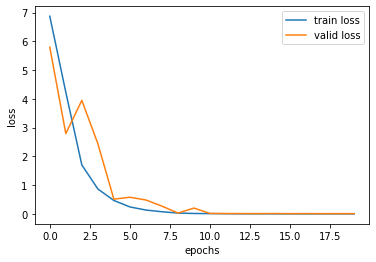

In [ ]:
from matplotlib import pyplot as plt
y = list(range(epochs))
train_loss = plt.plot(y, train_loss_list)
valid_loss = plt.plot(y, eval_loss_list)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend((train_loss[0], valid_loss[0]), ("train loss", "valid loss"),)
plt.show()

In [ ]:
torch.save(best_model.state_dict(), "/content/dirve/My Drive/Colab Notebooks/model/bert_embedded_transformer.pth")

In [ ]:
model.init_weights()
model.state_dict(torch.load("/content/dirve/My Drive/Colab Notebooks/model/bert_embedded_transformer.pth"))

In [ ]:
def gen_sentence(sentence, tok, model, max_len = 50):
  model.eval()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  sentence = tok.tokenize(sentence)
  src = [tok.convert_tokens_to_ids("[CLS]")] + tok.convert_tokens_to_ids(sentence) + [tok.convert_tokens_to_ids("[SEP]")]
  src = torch.LongTensor([src])
  # print(src)
  src = torch.t(src)
  src = src.to(device)

  src_tensor = model.encoder(src)
  src_tensor = model.pos_encoder(src_tensor).to(device)
  src_mask = model.generate_square_subsequent_mask(src_tensor.size()[0]).to(device)
  # print(src_tensor)
  with torch.no_grad():
    src_output = model.transformer_encoder(src_tensor, src_mask)
  trg = tok.convert_tokens_to_ids("[CLS]")
  trg = torch.LongTensor([[trg]]).to(device)
  output = []
  # print("src sizse: ", src_output.size())
  for i in range(max_len):
    # print("trg size: ", trg.size())
    trg_tensor = model.encoder(trg)
    # print(trg_tensor.size())
    trg_tensor = model.pos_encoder(trg_tensor).to(device)
    trg_mask = model.generate_square_subsequent_mask(trg_tensor.size()[0]).to(device)
    with torch.no_grad():
      pred = model.transformer_decoder(trg_tensor, src_output, trg_mask)
    # print("predicit sizes: ", pred.size())
    pred_word_index = pred.argmax(2)[-1]
    # add_word = trg_field.vocab.itos[pred_word_index.item()]
    # print(tok.convert_ids_to_tokens(pred_word_index))
    output.append(pred_word_index)
    if pred_word_index == 3:
      break

    last_index = torch.LongTensor([[pred_word_index.item()]]).to(device)
    trg = torch.cat((trg, last_index))
    
  # predict = "".join(output)
  predict = tok.convert_ids_to_tokens(output)
  predit = "".join(predict)

  return predict

In [ ]:
sentence = "なるほど"
gen_sentence(sentence, tok, model)

In [ ]:
def gen_sentence_list(path): 
  col, pred = [], []
  input, output = [], []
  with open(path, mode = 'r') as f:
    for file_list in f:
      col.append(file_list.split('\t'))
  for i in col:
    input.append(i[0])
    output.append(i[1].replace("\n", ""))

  for sentence in input:
    pred.append(gen_sentence(sentence, SRC, SRC, model))
  return input, output, pred

In [ ]:
import pandas as pd

In [ ]:
def convert_list_to_df(in_list, out_list, pred_list):
  row = []
  for i in range(len(in_list)):
    batch_input = in_list[i]
    batch_output = out_list[i]
    batch_pred = pred_list[i]
    input = [j for j in batch_input if j != "<pad>" and j != "<sos>" and j != "<eos>" and j != "<unk>"]
    output = [j for j in batch_output if j != "<pad>" and j != "<sos>" and j != "<eos>" and j != "<unk>"]
    predict = [j for j in batch_pred if j != "<pad>" and j != "<sos>" and j != "<eos>" and j != "<unk>"]
    input_str = "".join(input).replace("#", "")
    output_str ="".join(output).replace("#", "")
    predict_str = "".join(predict).replace("#", "")
    row.append([input_str, output_str, predict_str])

  df = pd.DataFrame(row, columns=["input","answer","predict"])
  df = df.sort_values('input')
  return df

In [ ]:
train_df = convert_list_to_df(train_in, train_out, train_pred)
val_df = convert_list_to_df(val_in, val_out, val_pred)
test_df = convert_list_to_df(test_in, test_out, test_pred)

In [ ]:
df_s = pd.concat([train_df, test_df]).sort_values('input')

In [ ]:
df_s.head(10)

In [ ]:
df_s.to_csv(filename)